# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Imports, Libraries and Load data

In [388]:
# import libraries here; add more as necessary
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
# magic word for producing visualizations in notebook
%matplotlib inline

In [389]:
def load_data():

  # load the general population data as a pandas dataframe
  general = pd.read_csv('', sep=';')
  # load the customers data as a pandas dataframe
  customers = pd.read_csv('', sep=';') 
  # load the top level attributes data as a pandas dataframe from an excel file
  attributes = pd.read_excel('', header = 1) 
  # load the detailed attribute mapping data as a pandas dataframe from the same excel file
  info = pd.read_excel('', header = 1) 

  
  return general, customers, attributes, info

# call the load_data function to get the data
general, customers, attributes, info = load_data() 


<ipython-input-389-bc63eb1e0e28>:16: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  general, customers, attributes, info = load_data()


## Part 0: Get to Know the Data



There are four data files associated with this project:

- `Udacity_general_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("general"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

#### Take a peek at the data

In [390]:
general.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                   NaN                  NaN  ...   
1          NaN          NaN                  21.0                 11.0  ...   
2          NaN          NaN                  17.0                 10.0  ...   
3          NaN          NaN                  13.0                  1.0  ...   
4          NaN          NaN                  14.0                  3.0  ...   

   VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0  NaN       NaN         NaN      NaN             NaN             NaN   
1  4.0       8.0        11.0     10.0             3.0             9.0   
2  2.0       9.0         9.0      6.0             3.0             9.0   
3  0.0       7.0        10.0     11.0             NaN             9.0   
4  2.0       3.0         5.0      4.0             2.0             9.0   

   WOHNLAGE ZABEOTYP ANREDE_KZ ALTERSKATEGORIE_GROB  
0       NaN        3         1                    2  
1       4.0        5         2                    1  
2       2.0        5         2                    3  
3       7.0        3         2                    4  
4       3.0        4         1                    3  

[5 rows x 366 columns]

In [391]:
customers.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626         2         1.0      10.0          NaN          NaN   
1    9628        -1         9.0      11.0          NaN          NaN   
2  143872        -1         1.0       6.0          NaN          NaN   
3  143873         1         1.0       8.0          NaN          NaN   
4  143874        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                  10.0                  1.0  ...   
1          NaN          NaN                   NaN                  NaN  ...   
2          NaN          NaN                   0.0                  1.0  ...   
3          NaN          NaN                   8.0                  0.0  ...   
4          NaN          NaN                  14.0                  7.0  ...   

   VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  ZABEOTYP  \
0      2.0             6.0             9.0       7.0         3   
1      3.0             0.0             9.0       NaN         3   
2     11.0             6.0             9.0       2.0         3   
3      2.0             NaN             9.0       7.0         1   
4      4.0             2.0             9.0       3.0         1   

       PRODUCT_GROUP  CUSTOMER_GROUP ONLINE_PURCHASE ANREDE_KZ  \
0  COSMETIC_AND_FOOD     MULTI_BUYER               0         1   
1               FOOD    SINGLE_BUYER               0         1   
2  COSMETIC_AND_FOOD     MULTI_BUYER               0         2   
3           COSMETIC     MULTI_BUYER               0         1   
4               FOOD     MULTI_BUYER               0         1   

  ALTERSKATEGORIE_GROB  
0                    4  
1                    4  
2                    4  
3                    4  
4                    3  

[5 rows x 369 columns]

In [392]:
attributes.head()

Unnamed: 0 Attribute         Description Value                     Meaning
0         NaN  AGER_TYP  best-ager typology    -1                     unknown
1         NaN       NaN                 NaN     0  no classification possible
2         NaN       NaN                 NaN     1             passive elderly
3         NaN       NaN                 NaN     2            cultural elderly
4         NaN       NaN                 NaN     3   experience-driven elderly

In [393]:
info.head()

Unnamed: 0 Information level             Attribute  \
0         NaN               NaN              AGER_TYP   
1         NaN            Person  ALTERSKATEGORIE_GROB   
2         NaN               NaN             ANREDE_KZ   
3         NaN               NaN         CJT_GESAMTTYP   
4         NaN               NaN     FINANZ_MINIMALIST   

                                         Description  \
0                                 best-ager typology   
1                      age through prename analysis    
2                                             gender   
3  Customer-Journey-Typology relating to the pref...   
4         financial typology: low financial interest   

                                    Additional notes  
0  in cooperation with Kantar TNS; the informatio...  
1  modelled on millions of first name-age-referen...  
2                                                NaN  
3  relating to the preferred information, marketi...  
4  Gfk-Typology based on a representative househo...

#### Data Exploration

In [394]:
print(f'General Population Dataset shape: {general.shape}')
print(f'Customer Dataset shape: {customers.shape}')

General Population Dataset shape: (891221, 366)
Customer Dataset shape: (191652, 369)


<AxesSubplot:>

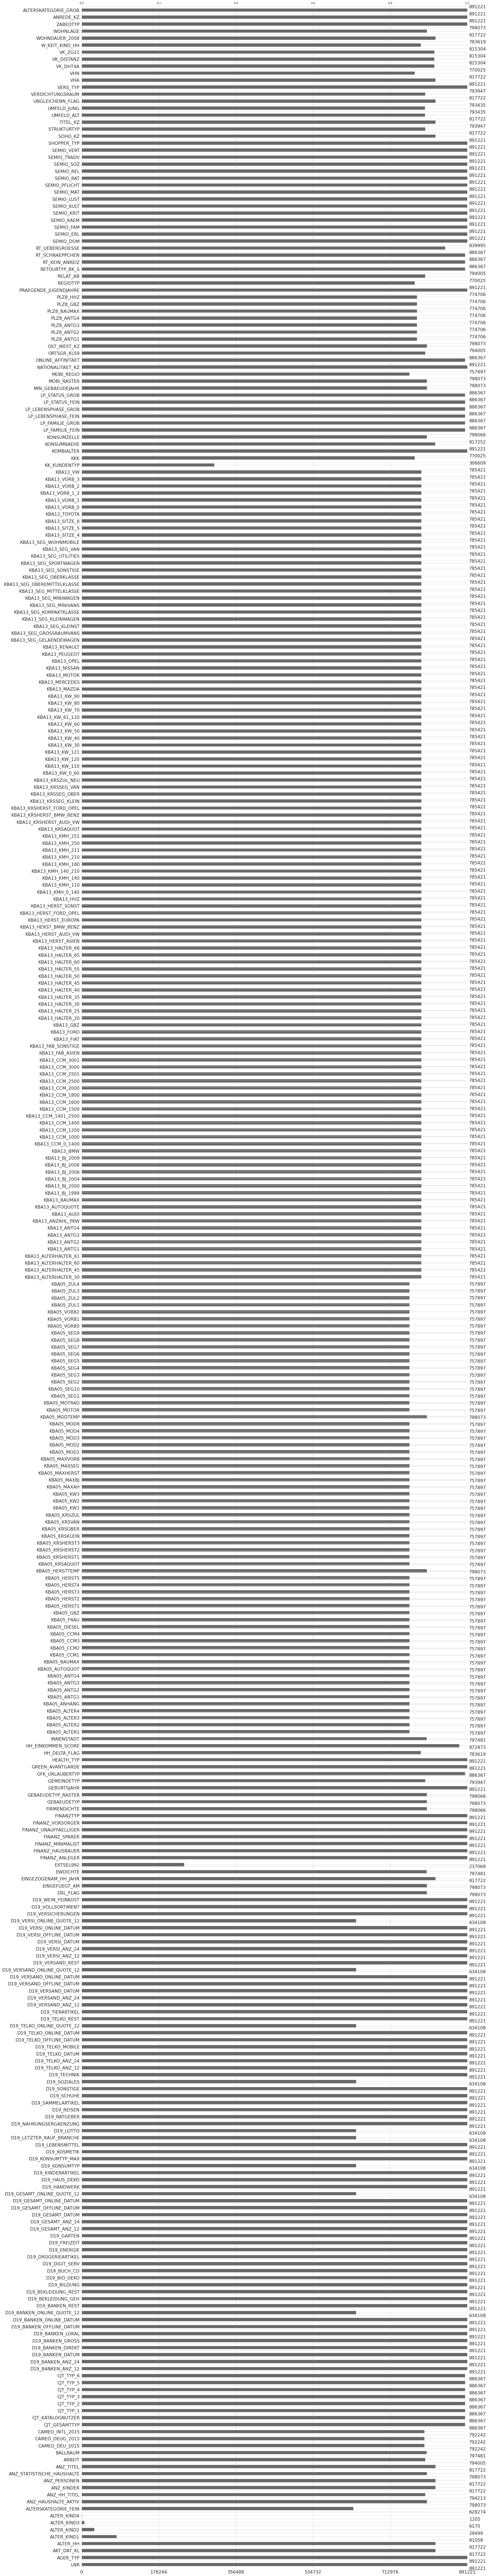

In [395]:
msno.bar(general)

<AxesSubplot:>

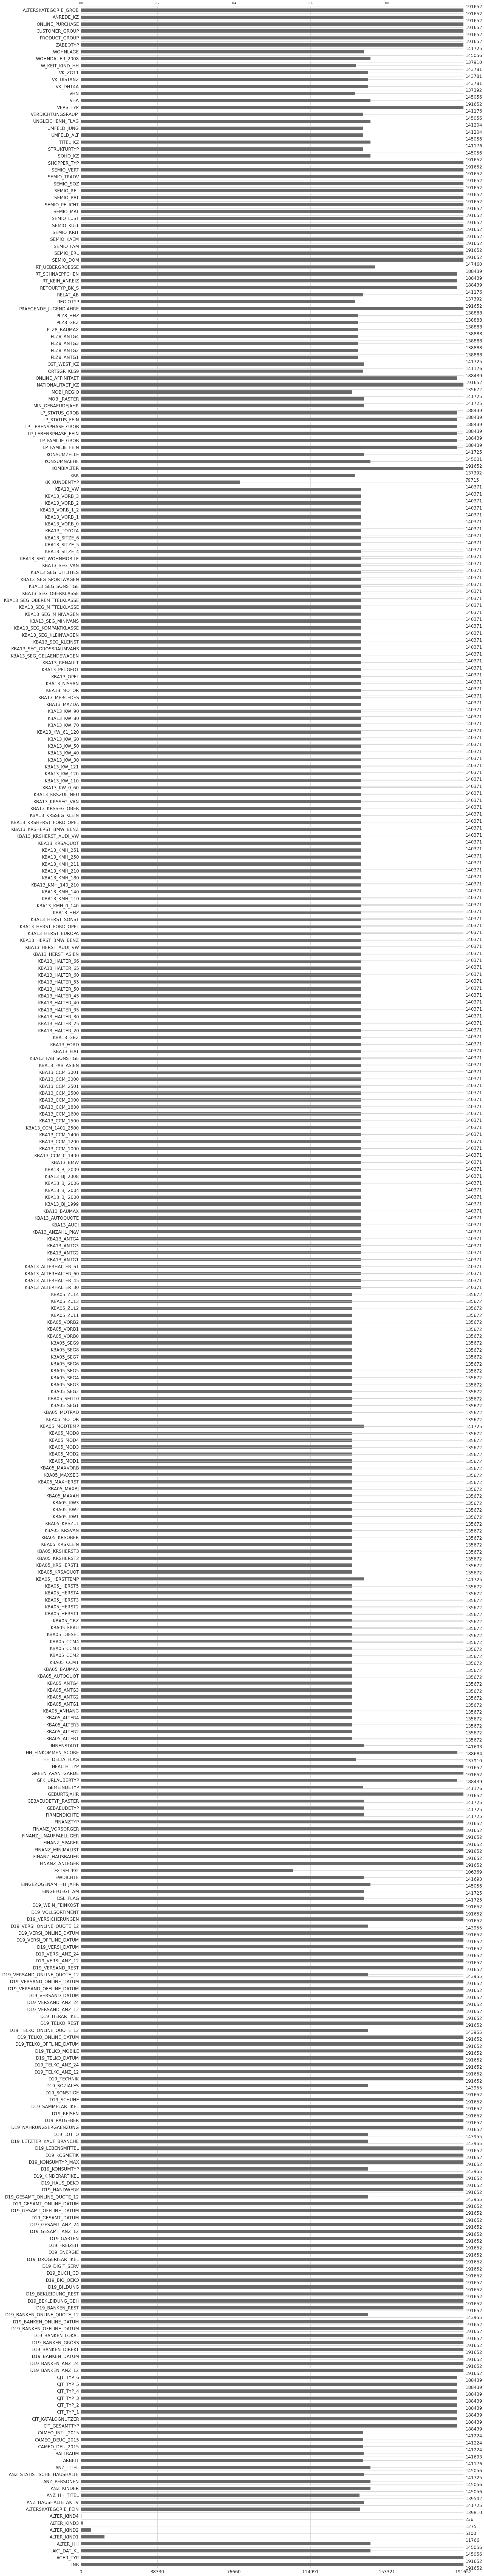

In [396]:
msno.bar(customers)

There is a lot of missing data in both the general and customers dataset.

In [397]:
general.describe()

LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  8.912210e+05  891221.000000  817722.000000  817722.000000   
mean   6.372630e+05      -0.358435       4.421928      10.864126   
std    2.572735e+05       1.198724       3.638805       7.639683   
min    1.916530e+05      -1.000000       1.000000       0.000000   
25%    4.144580e+05      -1.000000       1.000000       0.000000   
50%    6.372630e+05      -1.000000       3.000000      13.000000   
75%    8.600680e+05      -1.000000       9.000000      17.000000   
max    1.082873e+06       3.000000       9.000000      21.000000   

        ALTER_KIND1   ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  81058.000000  29499.000000  6170.000000  1205.000000   
mean      11.745392     13.402658    14.476013    15.089627   
std        4.097660      3.243300     2.712427     2.452932   
min        2.000000      2.000000     4.000000     7.000000   
25%        8.000000     11.000000    13.000000    14.000000   
50%       12.000000     14.000000    15.000000    15.000000   
75%       15.000000     16.000000    17.000000    17.000000   
max       18.000000     18.000000    18.000000    18.000000   

       ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...            VHN  \
count         628274.000000        798073.000000  ...  770025.000000   
mean              13.700717             8.287263  ...       2.417322   
std                5.079849            15.628087  ...       1.166572   
min                0.000000             0.000000  ...       0.000000   
25%               11.000000             1.000000  ...       2.000000   
50%               14.000000             4.000000  ...       2.000000   
75%               17.000000             9.000000  ...       3.000000   
max               25.000000           595.000000  ...       4.000000   

            VK_DHT4A     VK_DISTANZ        VK_ZG11  W_KEIT_KIND_HH  \
count  815304.000000  815304.000000  815304.000000   783619.000000   
mean        6.001214       7.532130       5.945972        3.933406   
std         2.856091       3.247789       2.771464        1.964701   
min         1.000000       1.000000       1.000000        0.000000   
25%         3.000000       5.000000       4.000000        2.000000   
50%         6.000000       8.000000       6.000000        4.000000   
75%         9.000000      10.000000       8.000000        6.000000   
max        11.000000      13.000000      11.000000        6.000000   

       WOHNDAUER_2008       WOHNLAGE       ZABEOTYP      ANREDE_KZ  \
count   817722.000000  798073.000000  891221.000000  891221.000000   
mean         7.908791       4.052836       3.362438       1.522098   
std          1.923137       1.949539       1.352704       0.499512   
min          1.000000       0.000000       1.000000       1.000000   
25%          8.000000       3.000000       3.000000       1.000000   
50%          9.000000       3.000000       3.000000       2.000000   
75%          9.000000       5.000000       4.000000       2.000000   
max          9.000000       8.000000       6.000000       2.000000   

       ALTERSKATEGORIE_GROB  
count         891221.000000  
mean               2.777398  
std                1.068775  
min                1.000000  
25%                2.000000  
50%                3.000000  
75%                4.000000  
max                9.000000  

[8 rows x 360 columns]

In [398]:
customers.describe()

LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  191652.000000  191652.000000  145056.000000  145056.000000   
mean    95826.500000       0.344359       1.747525      11.352009   
std     55325.311233       1.391672       1.966334       6.275026   
min         1.000000      -1.000000       1.000000       0.000000   
25%     47913.750000      -1.000000       1.000000       8.000000   
50%     95826.500000       0.000000       1.000000      11.000000   
75%    143739.250000       2.000000       1.000000      16.000000   
max    191652.000000       3.000000       9.000000      21.000000   

        ALTER_KIND1  ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  11766.000000  5100.000000  1275.000000   236.000000   
mean      12.337243    13.672353    14.647059    15.377119   
std        4.006050     3.243335     2.753787     2.307653   
min        2.000000     2.000000     5.000000     8.000000   
25%        9.000000    11.000000    13.000000    14.000000   
50%       13.000000    14.000000    15.000000    16.000000   
75%       16.000000    16.000000    17.000000    17.000000   
max       18.000000    18.000000    18.000000    18.000000   

       ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...       VK_DHT4A  \
count         139810.000000        141725.000000  ...  143781.000000   
mean              10.331579             4.965863  ...       4.374417   
std                4.134828            14.309694  ...       2.924355   
min                0.000000             0.000000  ...       1.000000   
25%                9.000000             1.000000  ...       2.000000   
50%               10.000000             1.000000  ...       4.000000   
75%               13.000000             4.000000  ...       7.000000   
max               25.000000           523.000000  ...      11.000000   

          VK_DISTANZ        VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
count  143781.000000  143781.000000   137910.000000   145056.000000   
mean        4.564769       3.168868        4.152716        8.646371   
std         2.887035       2.233516        1.974375        1.154001   
min         1.000000       1.000000        0.000000        1.000000   
25%         2.000000       1.000000        2.000000        9.000000   
50%         4.000000       3.000000        5.000000        9.000000   
75%         7.000000       4.000000        6.000000        9.000000   
max        13.000000      11.000000        6.000000        9.000000   

            WOHNLAGE       ZABEOTYP  ONLINE_PURCHASE      ANREDE_KZ  \
count  141725.000000  191652.000000    191652.000000  191652.000000   
mean        3.723133       2.576806         0.090247       1.376432   
std         2.095540       1.168486         0.286536       0.484492   
min         0.000000       1.000000         0.000000       1.000000   
25%         2.000000       1.000000         0.000000       1.000000   
50%         3.000000       3.000000         0.000000       1.000000   
75%         5.000000       3.000000         0.000000       2.000000   
max         8.000000       6.000000         1.000000       2.000000   

       ALTERSKATEGORIE_GROB  
count         191652.000000  
mean               3.060907  
std                1.086254  
min                1.000000  
25%                3.000000  
50%                3.000000  
75%                4.000000  
max                9.000000  

[8 rows x 361 columns]

In [399]:
general.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [400]:
customers.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [401]:
extra_cols =  [col for col in customers.columns if col not in general.columns]
print(f'Extra columns in Customers Data: {extra_cols}')

Extra columns in Customers Data: ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


In [402]:
# Missing data
def cols_missing_data(df):
  # Count the number of non-missing values in each column
  counts = df.count()
  # Count the number of columns with non_missing data
  num_non_missing_columnss = sum(counts == len(df))

  return num_non_missing_columnss

In [403]:
print(f'Number of columns without missing data in general dataset {cols_missing_data(general)}')
print(f'Number of columns without missing data in Customers dataset {cols_missing_data(customers)}')

Number of columns without missing data in general dataset 93
Number of columns without missing data in Customers dataset 96


Wow, there is alot of cleaning to be done!

#### Dealing with DtypeWarning above

In [404]:
def process_18_19(df):
  '''
  This function takes a dataframe (df) as an input and performs the following operations:

  Replaces 'X' values with NaN in column 18
  Replaces 'XX' values with NaN in column 19
  Converts column 18 and 19 to float data type
  '''

  df[df.columns[18]].replace({'X':np.nan}, inplace=True)
  df[df.columns[19]].replace({'XX':np.nan}, inplace=True)

  df[df.columns[18]]=df[df.columns[18]].astype(float)
  df[df.columns[19]]=df[df.columns[19]].astype(float)

process_18_19(general)
process_18_19(customers)

#### Explore, Process Attributes and Info data

###### Info

In [405]:
info.head()

Unnamed: 0 Information level             Attribute  \
0         NaN               NaN              AGER_TYP   
1         NaN            Person  ALTERSKATEGORIE_GROB   
2         NaN               NaN             ANREDE_KZ   
3         NaN               NaN         CJT_GESAMTTYP   
4         NaN               NaN     FINANZ_MINIMALIST   

                                         Description  \
0                                 best-ager typology   
1                      age through prename analysis    
2                                             gender   
3  Customer-Journey-Typology relating to the pref...   
4         financial typology: low financial interest   

                                    Additional notes  
0  in cooperation with Kantar TNS; the informatio...  
1  modelled on millions of first name-age-referen...  
2                                                NaN  
3  relating to the preferred information, marketi...  
4  Gfk-Typology based on a representative househo...

In [406]:
info.drop(columns='Unnamed: 0', inplace=True)
info['Information level'] = info['Information level'].fillna(method='ffill').fillna(method='bfill')
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Information level  313 non-null    object
 1   Attribute          313 non-null    object
 2   Description        313 non-null    object
 3   Additional notes   20 non-null     object
dtypes: object(4)
memory usage: 9.9+ KB


In [407]:
info

Information level             Attribute  \
0              Person              AGER_TYP   
1              Person  ALTERSKATEGORIE_GROB   
2              Person             ANREDE_KZ   
3              Person         CJT_GESAMTTYP   
4              Person     FINANZ_MINIMALIST   
..                ...                   ...   
308         Community                ARBEIT   
309         Community             EINWOHNER   
310         Community                   GKZ   
311         Community           ORTSGR_KLS9   
312         Community              RELAT_AB   

                                           Description  \
0                                   best-ager typology   
1                        age through prename analysis    
2                                               gender   
3    Customer-Journey-Typology relating to the pref...   
4           financial typology: low financial interest   
..                                                 ...   
308        share of unemployed person in the community   
309                                        inhabitants   
310                        standardized community-code   
311                   classified number of inhabitants   
312  share of unemployed in relation to the county ...   

                                      Additional notes  
0    in cooperation with Kantar TNS; the informatio...  
1    modelled on millions of first name-age-referen...  
2                                                  NaN  
3    relating to the preferred information, marketi...  
4    Gfk-Typology based on a representative househo...  
..                                                 ...  
308                                                NaN  
309                                                NaN  
310                                                NaN  
311                                                NaN  
312                                                NaN  

[313 rows x 4 columns]

###### Attributes

In [408]:
attributes.head()

Unnamed: 0 Attribute         Description Value                     Meaning
0         NaN  AGER_TYP  best-ager typology    -1                     unknown
1         NaN       NaN                 NaN     0  no classification possible
2         NaN       NaN                 NaN     1             passive elderly
3         NaN       NaN                 NaN     2            cultural elderly
4         NaN       NaN                 NaN     3   experience-driven elderly

In [409]:
attributes.drop(columns='Unnamed: 0', inplace=True)
attributes['Attribute'] = attributes['Attribute'].fillna(method='ffill')
attributes['Description'] = attributes['Description'].fillna(method='ffill')
attributes

Attribute                       Description Value  \
0     AGER_TYP                best-ager typology    -1   
1     AGER_TYP                best-ager typology     0   
2     AGER_TYP                best-ager typology     1   
3     AGER_TYP                best-ager typology     2   
4     AGER_TYP                best-ager typology     3   
...        ...                               ...   ...   
2253  ZABEOTYP  typification of energy consumers     2   
2254  ZABEOTYP  typification of energy consumers     3   
2255  ZABEOTYP  typification of energy consumers     4   
2256  ZABEOTYP  typification of energy consumers     5   
2257  ZABEOTYP  typification of energy consumers     6   

                         Meaning  
0                        unknown  
1     no classification possible  
2                passive elderly  
3               cultural elderly  
4      experience-driven elderly  
...                          ...  
2253                       smart  
2254               fair supplied  
2255                price driven  
2256         seeking orientation  
2257                 indifferent  

[2258 rows x 4 columns]

#### Dealing with Missing values

##### Missing Columns

In [410]:
def missing_columns(df):
    """
    Returns the percentage of missing values for each column of a pandas DataFrame
    """
    # percent = df.isnull().sum() / len(df) * 100
    percent = df.isnull().mean()*100
    missing_data = pd.DataFrame({'column_name': percent.index,
                                'percent_missing': percent.values})
    missing_data.replace(0, pd.NA, inplace=True)
    missing_data.dropna(inplace=True)
    missing_data.sort_values('percent_missing', ascending=False, inplace=True)  
    return missing_data

In [411]:
general_missing_cols = missing_columns(general)
customers_missing_cols = missing_columns(customers)

The attributes tells us about the possible range of values a column can have. We can use this information to process the columns and find unknown data

In [412]:
# Create an empty dictionary to store attribute values where meaning is "unknown"
attr_values = {} 

# Loop through each row in the attributes DataFrame
for index, row in attributes.iterrows():
  # Check if the "Meaning" column for the current row contains "unknown"
  if 'unknown' in str(row['Meaning']):
    # If the "Meaning" column contains "unknown", add a new entry to the dictionary
    # The key is the "Attribute" column value, and the value is a list of integers
    values_list = [int(num) for num in str(row['Value']).split(', ')]
    attribute_name = row['Attribute']
    attr_values[attribute_name] = values_list


In [413]:
def replacing_unknown_with_nan(df, dictionary):
    cols = [col for col in df.columns if col in dictionary]
    df[cols] = df[cols].apply(lambda x: x.replace(dictionary.get(x.name, []), np.nan))

In [414]:
# replace with np.nan
replacing_unknown_with_nan(general, attr_values)
replacing_unknown_with_nan(customers, attr_values)

There are some columns in the **general** and **customers** datasets that do not exist in the **DIAS_attribute** dataset. These columns should be dropped as they lack descriptions and therefore cannot be properly understood or interpreted.

In [415]:
def cols_not_in_attr(df, attributes=attributes):
  df_cols = df.columns.tolist()
  attr_cols = attributes.Attribute.unique().tolist()

  difference = list(set(df_cols) - set(attr_cols))
  return difference

In [416]:
general_missing_cols = missing_columns(general)
customers_missing_cols = missing_columns(customers)
cols_to_drop = general_missing_cols[general_missing_cols['percent_missing']>70]['column_name'].tolist()
cols_to_drop1 = customers_missing_cols[customers_missing_cols['percent_missing']>70]['column_name'].tolist()

cols_to_drop2 = cols_not_in_attr(general, attributes=attributes)

In [417]:
cols_to_drop.extend(cols_to_drop1)
cols_to_drop.extend(cols_to_drop2)

In [418]:
def drop_columns(df, columns_to_drop):
    """
    Drops columns from a pandas dataframe based on a list of column names
    
    Parameters:
    df (pandas.DataFrame): The input dataframe
    columns_to_drop (list): A list of column names to drop from the dataframe
    
    Returns:
    pandas.DataFrame: The modified dataframe with the specified columns dropped inplace
    """
    print(f'Before : {df.shape}')
    try:
      df.drop(columns=columns_to_drop, axis = 1, inplace=True)
      print(f'After : {df.shape}')
    except:
      print('Unable to drop column')

In [419]:
# dropping appropriate columns from general
drop_columns(general, cols_to_drop)

Before : (891221, 366)
After : (891221, 270)


In [420]:
# dropping appropriate columns from customers
drop_columns(customers, cols_to_drop)

Before : (191652, 369)
After : (191652, 273)


##### Missing Rows

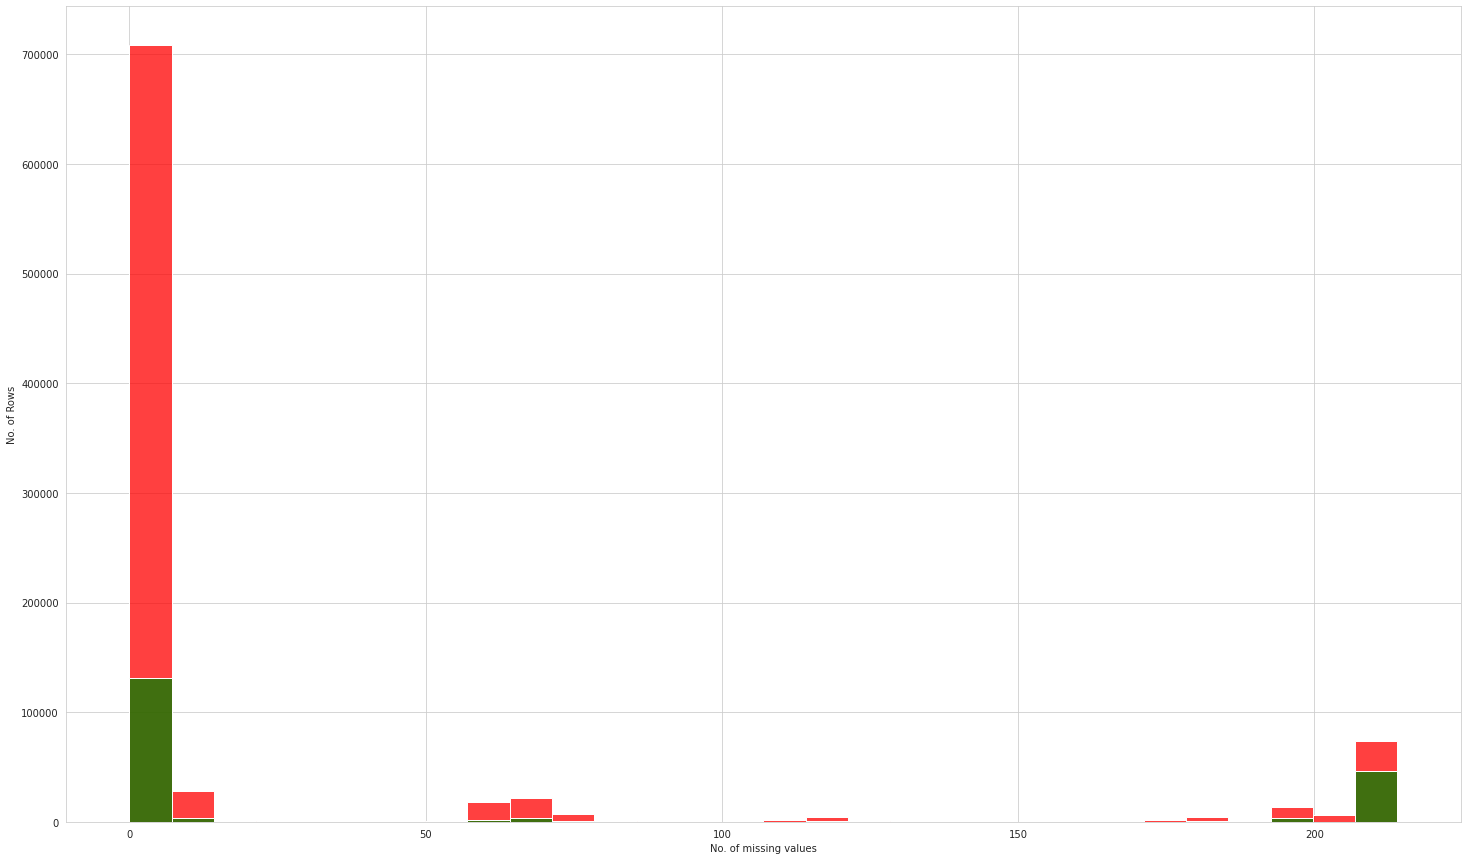

In [421]:
fig= plt.figure(figsize=(25,15))
sns.histplot(general.isna().sum(axis=1), bins=30, label = 'general', color = 'red')
sns.histplot(customers.isna().sum(axis=1), bins=30, label = 'Customers', color = 'green')
plt.xlabel('No. of missing values')
plt.ylabel('No. of Rows')
plt.show()

In [422]:
def remove_missing_rows(df, threshold):
    """
    Drops rows with missing values more than a certain percentage
    
    Parameters:
    df (pandas.DataFrame): The input dataframe
    pandas.DataFrame: The modified dataframe with the specified rows dropped 
    threshold (float): The percentage of missing values above which rows will be dropped inplace
    
    Returns:
    pandas.DataFrame: The modified dataframe with the specified rows dropped 
    """
    # calculate percentage of missing values per row
    missing_percentages = df.isna().mean(axis=1)
    print(f'Before: {df.shape[0]} rows')
    # drop rows with missing values more than the threshold
    df.dropna(thresh=len(df.columns) - threshold, inplace=True)
    
    print(f'After: {df.shape[0]} rows')

In [423]:
# dropping appropriate rows from general
remove_missing_rows(general, 50)

Before: 891221 rows
After: 737288 rows


In [424]:
# dropping appropriate rows from customers
remove_missing_rows(customers, 50)

Before: 191652 rows
After: 134246 rows


#### Categorical Data

In [425]:
def float_dtypes(df):
  float_columns = list(general.select_dtypes(include=['float']).columns)
  print(f'Float dtypes: {float_columns}')

def object_dtypes(df):
  O_columns = list(df.select_dtypes(include=['O']).columns)
  print(f'Object dtypes: {O_columns}')

def int_dtypes(df):
  int_columns = list(df.select_dtypes(include=['int']).columns)
  print(f'Int dtypes: {int_columns}')

In [426]:
float_dtypes(general)
int_dtypes(general)
object_dtypes(general)

Float dtypes: ['ALTER_HH', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'BALLRAUM', 'CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_VERSAND_ONLINE_QUOTE_12', 'EWDICHTE', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'HH_EINKOMMEN_SCORE', 'INNENSTADT', 'KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_AUTOQUOT', 'KBA05_BAUMAX', 'KBA05_CCM1', 'KBA05_CCM2', 'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU', 'KBA05_GBZ', 'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3', 'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_HERSTTEMP', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3', 'KBA05_KRSKLEIN', 'KBA05_KRSOBER', 'KBA05_KRSVAN', 'KBA05_KRSZUL', 'KBA05_KW1', 'KBA05_KW2', 'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MAXBJ', 'KBA05_MAXHERST', 'KBA05_MAXSEG', 'KBA05_MAXVORB

In [427]:
float_dtypes(customers)
int_dtypes(customers)
object_dtypes(customers)

Float dtypes: ['ALTER_HH', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'BALLRAUM', 'CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_VERSAND_ONLINE_QUOTE_12', 'EWDICHTE', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'HH_EINKOMMEN_SCORE', 'INNENSTADT', 'KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_AUTOQUOT', 'KBA05_BAUMAX', 'KBA05_CCM1', 'KBA05_CCM2', 'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU', 'KBA05_GBZ', 'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3', 'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_HERSTTEMP', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3', 'KBA05_KRSKLEIN', 'KBA05_KRSOBER', 'KBA05_KRSVAN', 'KBA05_KRSZUL', 'KBA05_KW1', 'KBA05_KW2', 'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MAXBJ', 'KBA05_MAXHERST', 'KBA05_MAXSEG', 'KBA05_MAXVORB

Drop the **CAMEO_DEU_2015** column from the dataframe and convert **OST_WEST_KZ** into a binary categorical variable.

In [428]:
drop_columns(general, 'CAMEO_DEU_2015')
drop_columns(customers, 'CAMEO_DEU_2015')

Before : (737288, 270)
After : (737288, 269)
Before : (134246, 273)
After : (134246, 272)


##### Encoding columns

In [429]:
customers['CUSTOMER_GROUP'].replace('SINGLE_BUYER', 0, inplace=True)
customers['CUSTOMER_GROUP'].replace('MULTI_BUYER', 1, inplace=True)

In [430]:
general['OST_WEST_KZ'].replace('O', 0, inplace=True)
general['OST_WEST_KZ'].replace('W', 1, inplace=True)
customers['OST_WEST_KZ'].replace('O', 0, inplace=True)
customers['OST_WEST_KZ'].replace('W', 1, inplace=True)

In [431]:
customers['PRODUCT_GROUP'].replace('COSMETIC_AND_FOOD', 0, inplace=True)
customers['PRODUCT_GROUP'].replace('FOOD', 1, inplace=True)
customers['PRODUCT_GROUP'].replace('COSMETIC', 2, inplace=True)

#### Imputing Missing Data and Standardizing Data

In [432]:
def impute_missing_values(df, missing_values=np.nan,strategy='most_frequent'):
    """
    This function imputes missing values in a pandas DataFrame using SimpleImputer from scikit-learn.
    :param df: The pandas DataFrame containing missing values.
    :param strategy: The imputation strategy to use. Valid options are 'mean', 'median', 'most_frequent', or 'constant'.
    :param fill_value: If the 'constant' strategy is used, this is the value to fill in for missing values.
    :return: A new pandas DataFrame with missing values imputed.
    """
    imputer = SimpleImputer(missing_values= missing_values, strategy=strategy)
    imputed_data = imputer.fit_transform(df)
    return pd.DataFrame(imputed_data, columns=df.columns)

In [433]:
general = impute_missing_values(general)
customers = impute_missing_values(customers)

<AxesSubplot:>

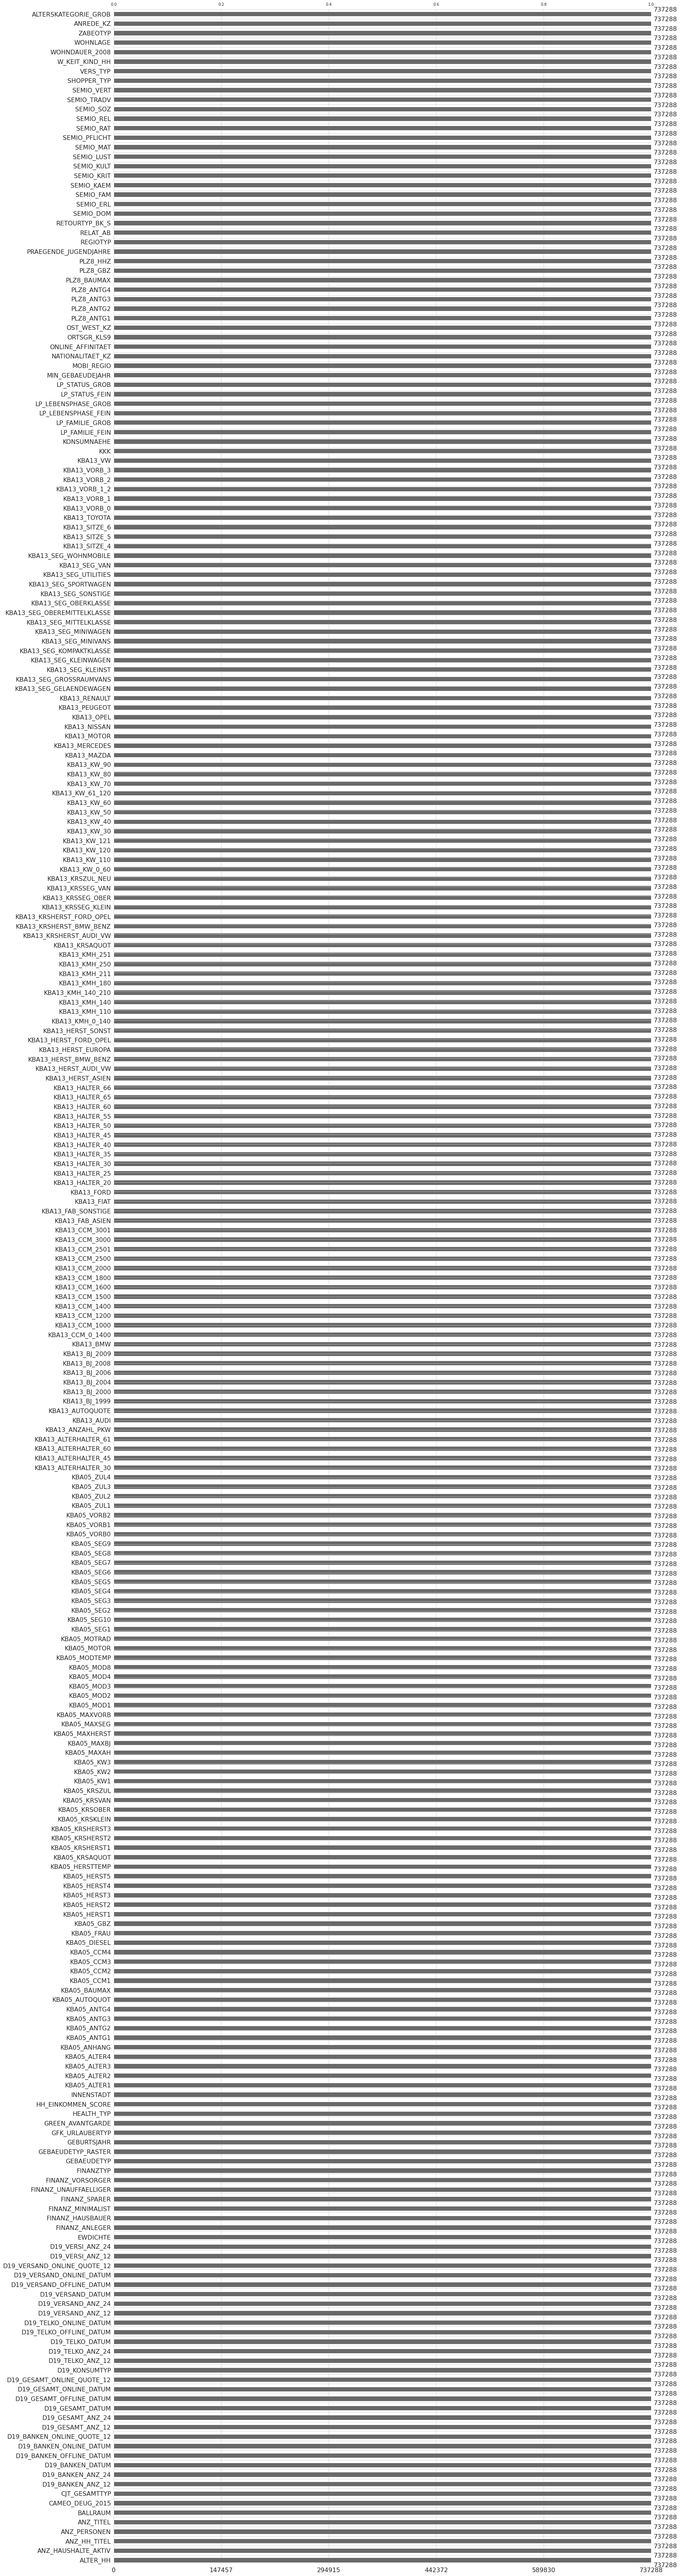

In [434]:
msno.bar(general)

<AxesSubplot:>

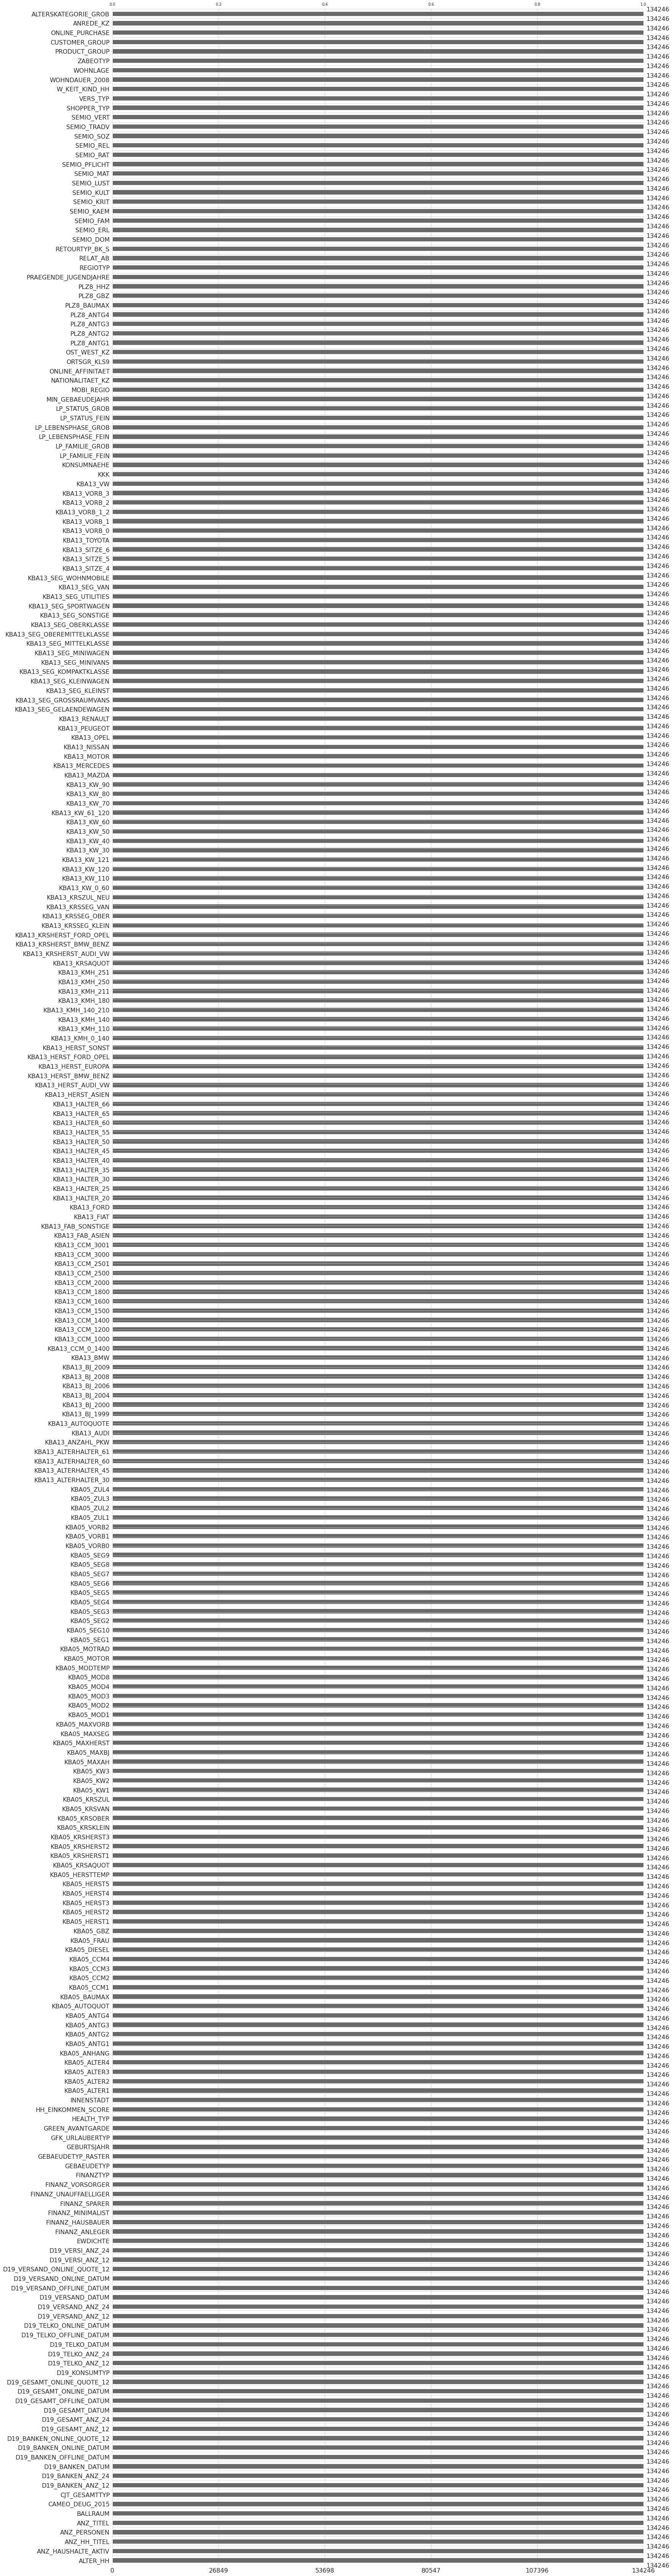

In [435]:
msno.bar(customers)

There are no more missing data. Yaaay!!!

##### Standardizing Data

In [436]:
def log_standardize(df):
    # perform log transformation on all columns
    df_log = np.log(df)

    # replace negative infinity values with a small number
    df_log.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_log.fillna(-1e9, inplace=True)

    # standardize the transformed data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_log)

    # create a new DataFrame with the standardized data
    df_standardized = pd.DataFrame(df_scaled, index=df.index, columns=df.columns)

    return df_standardized

In [437]:
general = log_standardize(general)
general

ALTER_HH  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL  \
0       0.560150             0.087877     -0.173863      0.207317  -0.062425   
1       0.336771             0.087877     -0.173863      0.207317  -0.062425   
2      -0.711622             0.087877     -0.173863     -4.823532  -0.062425   
3       0.971906             0.087877     -0.173863      0.207317  -0.062425   
4      -1.736958             0.087877     -0.173863      0.207317  -0.062425   
...          ...                  ...           ...           ...        ...   
737283  0.336771             0.087877     -0.173863      0.207317  -0.062425   
737284  0.099846             0.087877     -0.173863      0.207317  -0.062425   
737285  0.336771             0.087877     -0.173863     -4.823532  -0.062425   
737286  0.560150             0.087877     -0.173863      0.207317  -0.062425   
737287  0.560150             0.087877     -0.173863      0.207317  -0.062425   

        BALLRAUM  CAMEO_DEUG_2015  CJT_GESAMTTYP  D19_BANKEN_ANZ_12  \
0       0.810888         0.855408       0.895546          -0.278807   
1      -0.735594        -0.329934      -0.060304          -0.278807   
2       0.240127        -1.515277      -0.819005          -0.278807   
3      -0.735594         0.363447       0.895546           3.586716   
4       0.810888         0.855408      -0.819005          -0.278807   
...          ...              ...            ...                ...   
737283  0.810888         0.627058       0.895546          -0.278807   
737284  1.027880         1.056828       0.478003          -0.278807   
737285  0.554239        -0.329934       0.478003          -0.278807   
737286 -0.735594         1.056828      -0.060304          -0.278807   
737287  0.810888         0.363447      -2.116012          -0.278807   

        D19_BANKEN_ANZ_24  ...  SEMIO_TRADV  SEMIO_VERT  SHOPPER_TYP  \
0               -0.365106  ...     1.091837   -2.344670     0.448850   
1               -0.365106  ...    -0.138893    0.135275     0.448850   
2               -0.365106  ...     0.371906    0.135275     0.448850   
3                2.738931  ...    -0.858824    1.136373     0.448850   
4               -0.365106  ...     1.091837   -1.104697    -2.227918   
...                   ...  ...          ...         ...          ...   
737283          -0.365106  ...    -0.858824   -1.104697     0.448850   
737284          -0.365106  ...    -0.858824    0.135275     0.448850   
737285          -0.365106  ...     1.365542   -1.104697     0.448850   
737286          -0.365106  ...     0.768112    0.860612    -2.227918   
737287          -0.365106  ...    -0.858824    0.860612     0.448850   

        VERS_TYP  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  ZABEOTYP  \
0       0.907560       -0.420376        0.503440  0.004802  0.946660   
1      -1.101855       -0.420376        0.503440  0.004802  0.946660   
2      -1.101855        0.804491        0.503440  0.004802 -0.011877   
3       0.907560       -1.136877        0.503440  0.004802  0.527943   
4       0.907560        0.804491        0.503440  0.004802  0.527943   
...          ...             ...             ...       ...       ...   
737283 -1.101855       -0.420376       -1.969211  0.004802  0.527943   
737284  0.907560        0.804491        0.503440  0.004802  1.288776   
737285 -1.101855        0.804491       -1.288812  0.004802  0.527943   
737286  0.907560       -2.361744        0.503440  0.004802  0.946660   
737287 -1.101855        0.804491       -2.846398  0.004802 -0.011877   

        ANREDE_KZ  ALTERSKATEGORIE_GROB  
0        0.958448             -2.011622  
1        0.958448              0.333506  
2        0.958448              0.947599  
3       -1.043354              0.333506  
4        0.958448             -2.011622  
...           ...                   ...  
737283   0.958448              0.333506  
737284  -1.043354             -0.532011  
737285   0.958448             -0.532011  
737286  -1.043354             -2.011622  
73

In [438]:
customers = log_standardize(customers)
customers

ALTER_HH  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL  \
0      -0.615418             0.131560     -0.209454      0.224694  -0.139622   
1      -2.191516             0.131560     -0.209454      0.224694  -0.139622   
2      -1.303903            -7.601099     -0.209454     -4.450492  -0.139622   
3       1.523213             0.131560     -0.209454      0.224694  -0.139622   
4      -0.321349             0.131560     -0.209454      0.224694  -0.139622   
...          ...                  ...           ...           ...        ...   
134241 -0.940497             0.131560     -0.209454      0.224694  -0.139622   
134242 -0.615418            -7.601099     -0.209454     -4.450492  -0.139622   
134243  0.635601             0.131560     -0.209454      0.224694  -0.139622   
134244  0.194079             0.131560     -0.209454      0.224694  -0.139622   
134245 -0.615418             0.131560     -0.209454      0.224694  -0.139622   

        BALLRAUM  CAMEO_DEUG_2015  CJT_GESAMTTYP  D19_BANKEN_ANZ_12  \
0      -0.264789        -1.932724       1.187444          -0.293723   
1       0.998175         0.503640      -0.477523          -0.293723   
2       0.998175         0.165846      -0.477523          -0.293723   
3      -0.264789         1.012991       1.518735           3.404566   
4       0.998175         0.503640       0.781976          -0.293723   
...          ...              ...            ...                ...   
134241 -1.902356        -1.932724       0.781976          -0.293723   
134242  0.768401         0.503640      -0.477523          -0.293723   
134243  0.998175         0.165846      -0.477523          -0.293723   
134244 -0.264789         0.165846       0.781976           3.404566   
134245 -0.264789         0.503640      -0.477523           3.404566   

        D19_BANKEN_ANZ_24  ...  VERS_TYP  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0               -0.374834  ... -1.024433        0.775988        0.249792   
1               -0.374834  ...  0.976150        0.775988        0.249792   
2               -0.374834  ... -1.024433        0.775988        0.249792   
3                2.667851  ...  0.976150       -1.126720        0.249792   
4               -0.374834  ...  0.976150        0.775988        0.249792   
...                   ...  ...       ...             ...             ...   
134241           2.667851  ...  0.976150        0.775988        0.249792   
134242          -0.374834  ...  0.976150        0.775988        0.249792   
134243          -0.374834  ... -1.024433       -0.424487        0.249792   
134244           2.667851  ... -1.024433        0.073755        0.249792   
134245           2.667851  ... -1.024433       -0.424487        0.249792   

        WOHNLAGE  ZABEOTYP  PRODUCT_GROUP  CUSTOMER_GROUP  ONLINE_PURCHASE  \
0        0.00386  0.654040      -0.924105        0.648021        -0.300714   
1        0.00386  0.654040      -0.924105        0.648021        -0.300714   
2        0.00386 -1.190872       1.082128        0.648021        -0.300714   
3        0.00386 -1.190872       1.082128        0.648021        -0.300714   
4        0.00386 -0.026863      -0.924105        0.648021        -0.300714   
...          ...       ...            ...             ...              ...   
134241   0.00386  0.654040      -0.924105        0.648021        -0.300714   
134242   0.00386  0.654040       1.082128       -1.543159        -0.300714   
134243   0.00386  0.654040      -0.924105        0.648021        -0.300714   
134244   0.00386  0.654040       1.082128       -1.543159        -0.300714   
134245   0.00386 -1.190872      -0.924105        0.648021        -0.300714   

        ANREDE_KZ  ALTERSKATEGORIE_GROB  
0       -0.699527              0.570673  
1        1.429537              0.570673  
2       -0.699527              0.570673  
3       -0.699527             -0.426785  
4       -0.699527             -0.426785  
...           ...                   ...  
134241  -0.699527             -0.426785  
134242  

## Part 1: Customer Segmentation Report


The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Dimensionality Reduction with PCA

In [439]:
def dimensionality_reduction(df, n_components=None):
  pca = PCA(n_components)
  df_pca = pca.fit_transform(df)
  return df_pca, pca

In [440]:
def plot_variance(pca):
    fig, ax = plt.subplots(figsize=(15, 6))
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(explained_variance, color='black')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('How many features are needed to explain variance?')

    i = np.argmax(explained_variance > 0.90)
    plt.hlines(y=.90, xmin=0, xmax=len(explained_variance),color='gold', linestyle = '--')
    plt.vlines(x=i, ymin=0, ymax=1, color='gold', linestyle ='--')
    plt.show()

    return i

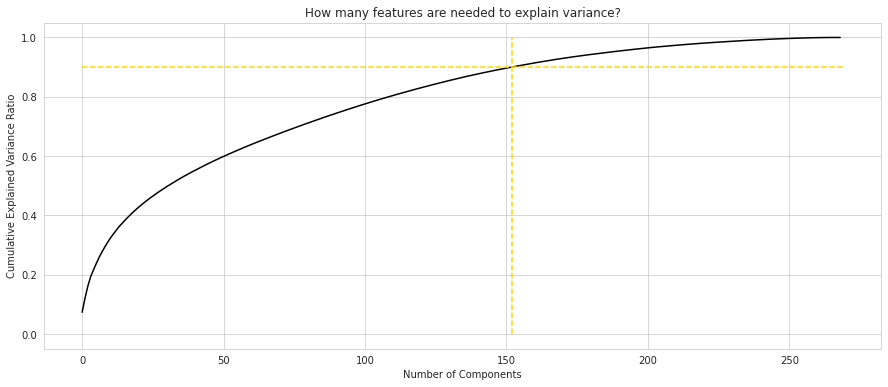

In [441]:
general_pca_transformed, general_pca = dimensionality_reduction(general)
num_components = plot_variance(general_pca)
# print(num_components)

In [442]:
general_pca_transformed, general_pca = dimensionality_reduction(general, num_components)

In [443]:
customers_pca_transformed, customers_pca = dimensionality_reduction(customers, num_components)

In [444]:
print("Before : ",general.shape)
print("After : ",general_pca_transformed.shape)

Before :  (737288, 269)
After :  (737288, 152)


In [445]:
print("Before : ",customers.shape)
print("After : ",customers_pca_transformed.shape)

Before :  (134246, 272)
After :  (134246, 152)


Using K-Means Algorithm

In [483]:
points = []
for i in range(2, 16):
  kmeans= KMeans(n_clusters=i, init='k-means++', random_state=42)
  kmeans.fit(general_pca_transformed)
  points.append(kmeans.inertia_)
  

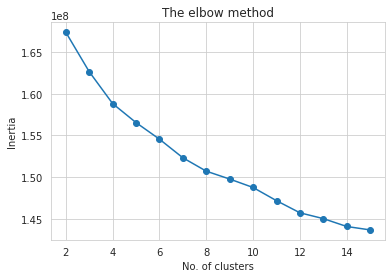

In [484]:
plt.plot(range(2,16), points, '-o')
plt.title("The elbow method")
plt.xlabel('No. of clusters')
plt.ylabel('Inertia')
plt.show()

Initiate K-Means

In [485]:
kmeans= KMeans(n_clusters=7, init='k-means++')
general_pred = kmeans.fit_predict(general_pca_transformed)
customers_pred=kmeans.fit_predict(customers_pca_transformed)

Visualizing the clusters

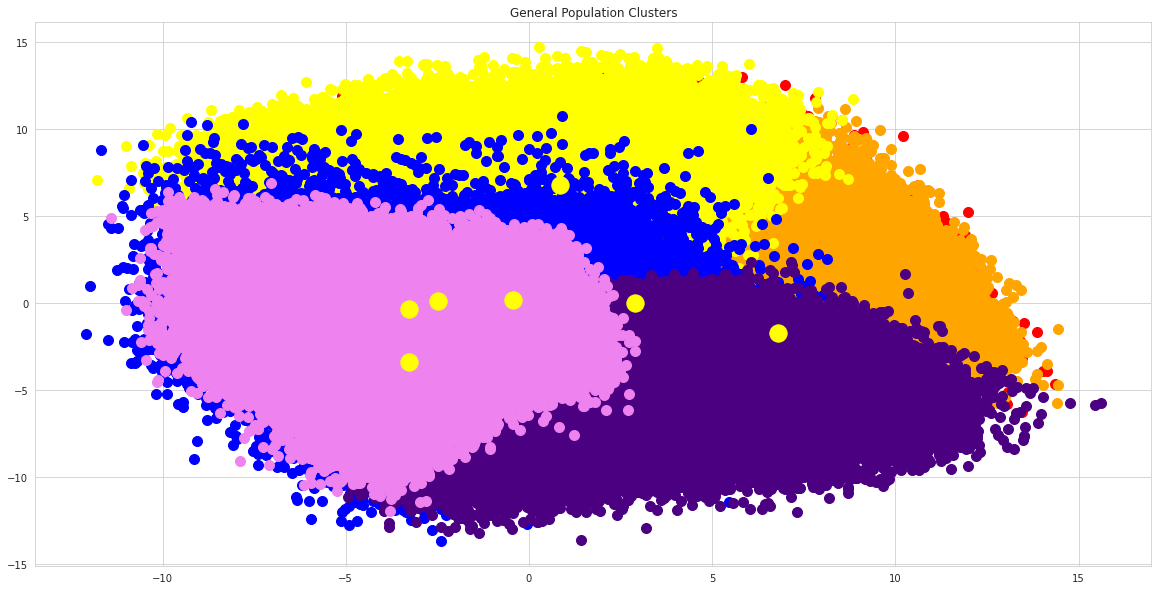

In [486]:
plt.figure(figsize=(20,10))
plt.scatter(general_pca_transformed[general_pred == 0, 0], general_pca_transformed[general_pred == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(general_pca_transformed[general_pred == 1, 0], general_pca_transformed[general_pred == 1, 1], s = 100, c = 'orange', label = 'Cluster 2')
plt.scatter(general_pca_transformed[general_pred == 2, 0], general_pca_transformed[general_pred == 2, 1], s = 100, c = 'yellow', label = 'Cluster 3')
plt.scatter(general_pca_transformed[general_pred == 3, 0], general_pca_transformed[general_pred == 3, 1], s = 100, c = 'green', label = 'Cluster 4')
plt.scatter(general_pca_transformed[general_pred == 4, 0], general_pca_transformed[general_pred == 4, 1], s = 100, c = 'blue', label = 'Cluster 5')
plt.scatter(general_pca_transformed[general_pred == 5, 0], general_pca_transformed[general_pred == 5, 1], s = 100, c = 'indigo', label = 'Cluster 6')
plt.scatter(general_pca_transformed[general_pred == 6, 0], general_pca_transformed[general_pred == 6, 1], s = 100, c = 'violet', label = 'Cluster 7')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('General Population Clusters')
plt.show()

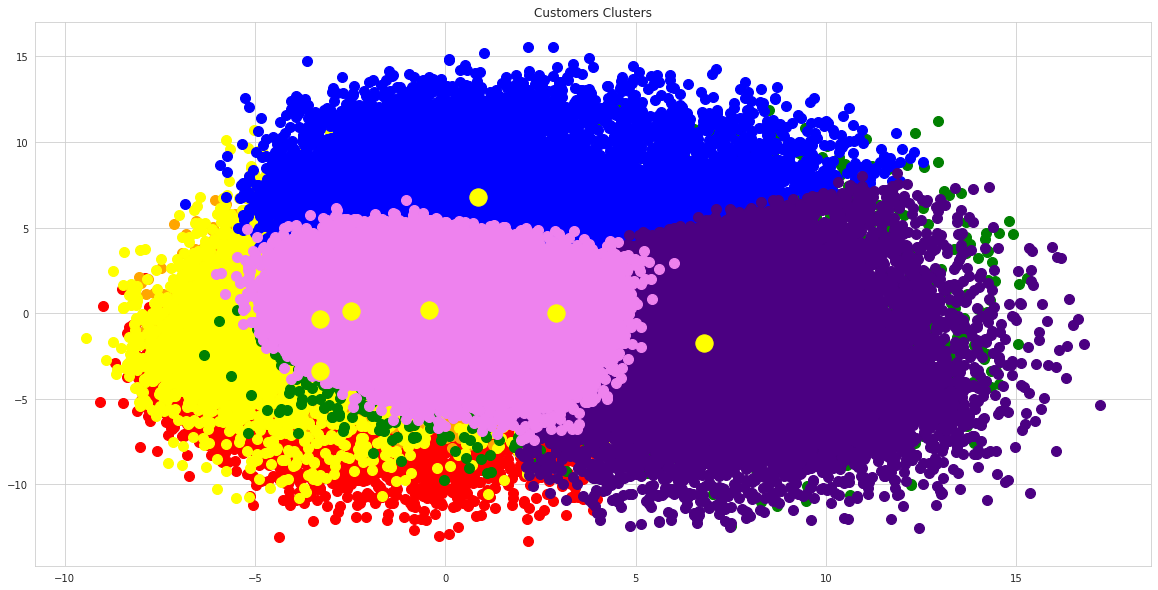

In [487]:
plt.figure(figsize=(20,10))
plt.scatter(customers_pca_transformed[customers_pred == 0, 0], customers_pca_transformed[customers_pred == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(customers_pca_transformed[customers_pred == 1, 0], customers_pca_transformed[customers_pred == 1, 1], s = 100, c = 'orange', label = 'Cluster 2')
plt.scatter(customers_pca_transformed[customers_pred == 2, 0], customers_pca_transformed[customers_pred == 2, 1], s = 100, c = 'yellow', label = 'Cluster 3')
plt.scatter(customers_pca_transformed[customers_pred == 3, 0], customers_pca_transformed[customers_pred == 3, 1], s = 100, c = 'green', label = 'Cluster 4')
plt.scatter(customers_pca_transformed[customers_pred == 4, 0], customers_pca_transformed[customers_pred == 4, 1], s = 100, c = 'blue', label = 'Cluster 5')
plt.scatter(customers_pca_transformed[customers_pred == 5, 0], customers_pca_transformed[customers_pred == 5, 1], s = 100, c = 'indigo', label = 'Cluster 6')
plt.scatter(customers_pca_transformed[customers_pred == 6, 0], customers_pca_transformed[customers_pred == 6, 1], s = 100, c = 'violet', label = 'Cluster 7')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Customers Clusters')
plt.show()

In [488]:
# create series for each dataset
general_pred = pd.Series(general_pred, name='general')
customers_pred = pd.Series(customers_pred, name='Customers')

# combine the series into a single DataFrame
clusters_df = pd.concat([general_pred.value_counts(), customers_pred.value_counts()], axis=1, sort=True)

# calculate percentages for each cluster in general and Customers
clusters_df['General'] = clusters_df['general'] * 100 / clusters_df['general'].sum()
clusters_df['Customer'] = clusters_df['Customers'] * 100 / clusters_df['Customers'].sum()

# calculate the difference in percentages between Customers and general for each cluster
clusters_df['percentage_difference'] = abs(clusters_df['Customer'] - clusters_df['General'])

# round the percentages and differences to 2 decimal places
clusters_df = clusters_df.round(2)
clusters_df

general  Customers  General  Customer  percentage_difference
0    24322      20079     3.30     14.96                  11.66
1   178033      27611    24.15     20.57                   3.58
2    70791       8573     9.60      6.39                   3.22
3   204775       5706    27.77      4.25                  23.52
4    44332      14757     6.01     10.99                   4.98
5    87341      21863    11.85     16.29                   4.44
6   127694      35657    17.32     26.56                   9.24

<Figure size 432x288 with 0 Axes>

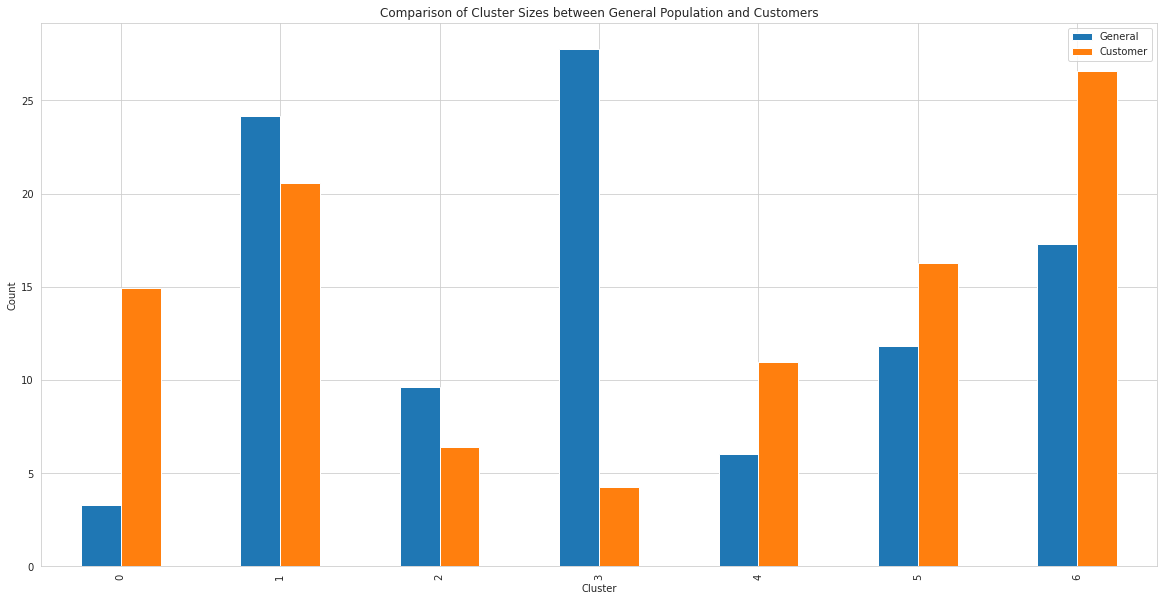

In [489]:
sns.set_style("whitegrid")
plt.figure()
clusters_df[['General', 'Customer']].plot(kind='bar', figsize=(20,10))
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Comparison of Cluster Sizes between General Population and Customers')
plt.show()

Based on the analysis, clusters 0, 4, 5, 6 appear to be more representative of the data and have a higher potential of becoming future customers. On the other hand, clusters 1, 2, 3 are less representative of the data and may not have as high of a potential to become future customers.

In [490]:
def combine_info(df, pca, kmeans, cluster, info=info):
    '''
    This function combines the demographic dataframe with the output of the KMeans and PCA,
    so that it's possible to understand which values from the columns describe the clusters. 
    
    Args: 
    df: demographic dataframe
    pca: pca model
    kmeans: kmeans model
    cluster: number of the cluster (index)
    
    Returns: 
    cluster_df: A pandas DataFrame with the following columns:
                - Values: values that describe the cluster.
                - Description: description of the attribute that the value corresponds to.
                - Information level: information level of the attribute.
    '''
    clusters_dict = dict(zip(df.columns, pca.inverse_transform(kmeans.cluster_centers_[cluster])))
    cluster_df = pd.DataFrame.from_dict(clusters_dict, 
                                        orient='index', 
                                        columns=['Values']).sort_values(by='Values')
    
    # Merge with info DataFrame to get attribute description and information level
    info = info[['Attribute', 'Description', 'Information level']]
    cluster_df = cluster_df.merge(info, left_index=True, right_on='Attribute')
    
    cluster_df.sort_values(by = 'Values', ascending=False, inplace=True)
    cluster_df.reset_index(drop = True, inplace = True)
    # Drop attribute column and reorder the columns
   
    
    return cluster_df[:10]

In [491]:
def print_cluster_def(cluster):
  print(f'This cluster is defined by the following attributes along with their descriptions')
  for i, row in cluster.iterrows():
    print(f'{row.Attribute:30} ==> {row.Description}')
  

##### REPRESENTATIVE CLUSTERS

In [496]:
cluster0 = combine_info(customers, customers_pca, kmeans, 0)
print_cluster_def(cluster0)

This cluster is defined by the following attributes along with their descriptions
KBA13_AUTOQUOTE                ==> share of cars per household within the PLZ8
KBA13_ALTERHALTER_60           ==> share of car owners between 46 and 60 within the PLZ8
KBA13_HALTER_50                ==> share of car owners between 46 and 50 within the PLZ8
KBA13_HALTER_55                ==> share of car owners between 51 and 55 within the PLZ8
INNENSTADT                     ==> distance to the city centre
BALLRAUM                       ==> distance to the next metropole
KBA13_SITZE_5                  ==> number of cars with 5 seats in the PLZ8
FINANZ_ANLEGER                 ==> financial typology: investor
KONSUMNAEHE                    ==> distance from a building to PoS (Point of Sale)
KBA05_AUTOQUOT                 ==> share of cars per household


In [494]:
cluster4 = combine_info(customers, customers_pca, kmeans, 4)
print_cluster_def(cluster4)

This cluster is defined by the following attributes along with their descriptions
KBA13_HERST_BMW_BENZ           ==> share of BMW & Mercedes Benz within the PLZ8
KBA13_SEG_OBEREMITTELKLASSE    ==> share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)
KBA13_KRSHERST_BMW_BENZ        ==> share of BMW/Mercedes Benz (referred to the county average) - PLZ8
KBA13_MERCEDES                 ==> share of MERCEDES within the PLZ8
KBA13_BMW                      ==> share of BMW within the PLZ8
KBA13_ALTERHALTER_61           ==> share of car owners elder than 60 within the PLZ8
KBA13_HALTER_66                ==> share of car owners over 66 within the PLZ8
KBA13_SITZE_4                  ==> number of cars with less than 5 seats in the PLZ8
KBA13_VORB_0                   ==> share of cars with no preowner - PLZ8
KBA13_HALTER_65                ==> share of car owners between 61 and 65 within the PLZ8


In [495]:
cluster5 = combine_info(customers, customers_pca, kmeans, 5)
print_cluster_def(cluster5)

This cluster is defined by the following attributes along with their descriptions
KBA05_BAUMAX                   ==> most common building-type within the cell
PLZ8_BAUMAX                    ==> most common building-type within the PLZ8
KBA05_ANTG4                    ==> number of >10 family houses in the cell
FINANZ_HAUSBAUER               ==> financial typology: main focus is the own house
KBA05_ANTG3                    ==> number of 6-10 family houses in the cell
HH_EINKOMMEN_SCORE             ==> estimated household_net_income 
CAMEO_DEUG_2015                ==> CAMEO_4.0: uppergroup
PLZ8_ANTG4                     ==> number of >10 family houses in the PLZ8
ZABEOTYP                       ==> typification of energy consumers
EWDICHTE                       ==> density of inhabitants per square kilometer


In [499]:
cluster6 = combine_info(customers, customers_pca, kmeans, 6)
print_cluster_def(cluster6)

This cluster is defined by the following attributes along with their descriptions
D19_VERSAND_DATUM              ==> actuality of the last transaction for the segment mail-order TOTAL
D19_GESAMT_DATUM               ==> actuality of the last transaction with the complete file TOTAL
D19_GESAMT_ONLINE_DATUM        ==> actuality of the last transaction with the complete file ONLINE
D19_VERSAND_ONLINE_DATUM       ==> actuality of the last transaction for the segment mail-order ONLINE
D19_KONSUMTYP                  ==> consumption type 
KBA05_ANTG1                    ==> number of 1-2 family houses in the cell
LP_STATUS_GROB                 ==> social status rough
D19_GESAMT_OFFLINE_DATUM       ==> actuality of the last transaction with the complete file OFFLINE
MOBI_REGIO                     ==> moving patterns
FINANZ_MINIMALIST              ==> financial typology: low financial interest


##### NON-REPRESENTATIVE CLUSTERS

In [492]:
cluster1 = combine_info(customers, customers_pca, kmeans, 1)
print_cluster_def(cluster1)


This cluster is defined by the following attributes along with their descriptions
D19_VERSAND_ONLINE_QUOTE_12    ==> amount of online transactions within all transactions in the segment mail-order 
D19_GESAMT_ONLINE_QUOTE_12     ==> amount of online transactions within all transactions in the complete file 
ALTER_HH                       ==> main age within the household
LP_STATUS_GROB                 ==> social status rough
LP_STATUS_FEIN                 ==> social status fine 
PRAEGENDE_JUGENDJAHRE          ==> dominating movement in the person's youth (avantgarde or mainstream)
MOBI_REGIO                     ==> moving patterns
KBA05_ANTG1                    ==> number of 1-2 family houses in the cell
GREEN_AVANTGARDE               ==> the environmental sustainability is the dominating movement in the youth of these consumers
KBA05_GBZ                      ==> number of buildings in the microcell


In [493]:
cluster2 = combine_info(customers, customers_pca, kmeans, 2)
print_cluster_def(cluster2)

This cluster is defined by the following attributes along with their descriptions
D19_BANKEN_ONLINE_QUOTE_12     ==> amount of online transactions within all transactions in the segment bank 
D19_GESAMT_ONLINE_QUOTE_12     ==> amount of online transactions within all transactions in the complete file 
ALTER_HH                       ==> main age within the household
D19_VERSAND_ONLINE_QUOTE_12    ==> amount of online transactions within all transactions in the segment mail-order 
MOBI_REGIO                     ==> moving patterns
CJT_GESAMTTYP                  ==> Customer-Journey-Typology relating to the preferred information and buying channels of consumers
KBA05_GBZ                      ==> number of buildings in the microcell
KBA05_ANTG1                    ==> number of 1-2 family houses in the cell
FINANZ_SPARER                  ==> financial typology: money saver
PRAEGENDE_JUGENDJAHRE          ==> dominating movement in the person's youth (avantgarde or mainstream)


In [497]:
cluster3 = combine_info(customers, customers_pca, kmeans, 3)
print_cluster_def(cluster3)

This cluster is defined by the following attributes along with their descriptions
D19_KONSUMTYP                  ==> consumption type 
W_KEIT_KIND_HH                 ==> likelihood of a child present in this household (can be specified in child age groups)
D19_GESAMT_DATUM               ==> actuality of the last transaction with the complete file TOTAL
D19_VERSAND_DATUM              ==> actuality of the last transaction for the segment mail-order TOTAL
D19_GESAMT_ONLINE_DATUM        ==> actuality of the last transaction with the complete file ONLINE
D19_VERSAND_ONLINE_DATUM       ==> actuality of the last transaction for the segment mail-order ONLINE
D19_GESAMT_OFFLINE_DATUM       ==> actuality of the last transaction with the complete file OFFLINE
D19_VERSAND_OFFLINE_DATUM      ==> actuality of the last transaction for the segment mail-order OFFLINE
SHOPPER_TYP                    ==> shopping typology
GEBAEUDETYP                    ==> type of building (residential or commercial)


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [500]:
mailout_train = pd.read_csv('', sep=';')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [501]:
sns.countplot(mailout_train.RESPONSE)
plt.show();

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


In [502]:
mailout_train.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  1763         2         1.0       8.0          NaN          NaN   
1  1771         1         4.0      13.0          NaN          NaN   
2  1776         1         1.0       9.0          NaN          NaN   
3  1460         2         1.0       6.0          NaN          NaN   
4  1783         2         1.0       9.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                   8.0                 15.0  ...   
1          NaN          NaN                  13.0                  1.0  ...   
2          NaN          NaN                   7.0                  0.0  ...   
3          NaN          NaN                   6.0                  4.0  ...   
4          NaN          NaN                   9.0                 53.0  ...   

   VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  \
0       5.0         2.0      1.0             6.0             9.0       3.0   
1       1.0         2.0      1.0             4.0             9.0       7.0   
2       6.0         4.0      2.0             NaN             9.0       2.0   
3       8.0        11.0     11.0             6.0             9.0       1.0   
4       2.0         2.0      1.0             6.0             9.0       3.0   

   ZABEOTYP RESPONSE ANREDE_KZ ALTERSKATEGORIE_GROB  
0         3        0         2                    4  
1         1        0         2                    3  
2         3        0         1                    4  
3         3        0         2                    4  
4         3        0         1                    3  

[5 rows x 367 columns]

In [503]:
# Deal with DtypeWarning above
process_18_19(mailout_train)

<AxesSubplot:>

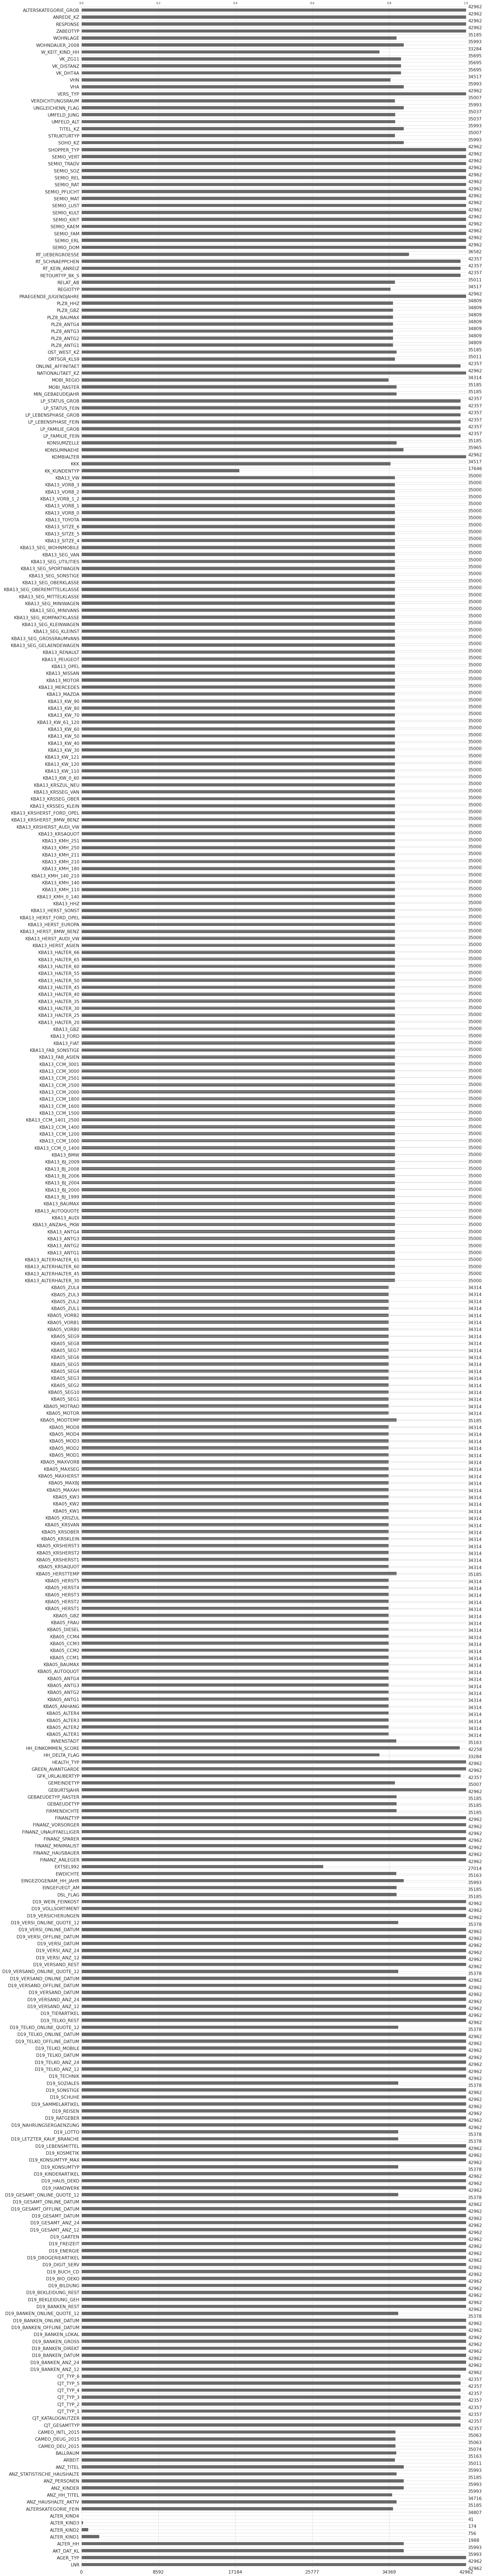

In [504]:
msno.bar(mailout_train)

In [505]:
# delete columns in mailout_train not in general and customers
drop_columns(mailout_train, cols_to_drop)

Before : (42962, 367)
After : (42962, 271)


In [506]:
def nominal_encoding(df, col):
    """
    Performs nominal encoding on a specified column of a Pandas DataFrame.
    
    Parameters:
    df (Pandas DataFrame): The DataFrame containing the column to be encoded.
    col (str): The name of the column to be encoded.
    
    Returns:
    encoded_df (Pandas DataFrame): The DataFrame with the specified column encoded.
    encoder (sklearn.preprocessing.LabelEncoder): The encoder object used to encode the column.
    """
    # Create a LabelEncoder object
    encoder = LabelEncoder()
    
    # Fit the encoder to the column of interest
    encoder.fit(df[col])
    
    # Transform the column
    encoded_col = encoder.transform(df[col])
    
    # Drop the original columns
    df = df.drop(col, axis=1)

    # Add the encoded column to the original DataFrame
    df[str(col) + '_encoded'] = encoded_col
    
    # Return the encoded DataFrame and encoder object
    return df, encoder

In [507]:
mailout_train, _ = nominal_encoding(mailout_train, 'CAMEO_DEU_2015')

In [508]:
float_dtypes(mailout_train)
int_dtypes(mailout_train)
object_dtypes(mailout_train)

Float dtypes: ['ALTER_HH', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'BALLRAUM', 'CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'EWDICHTE', 'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEA

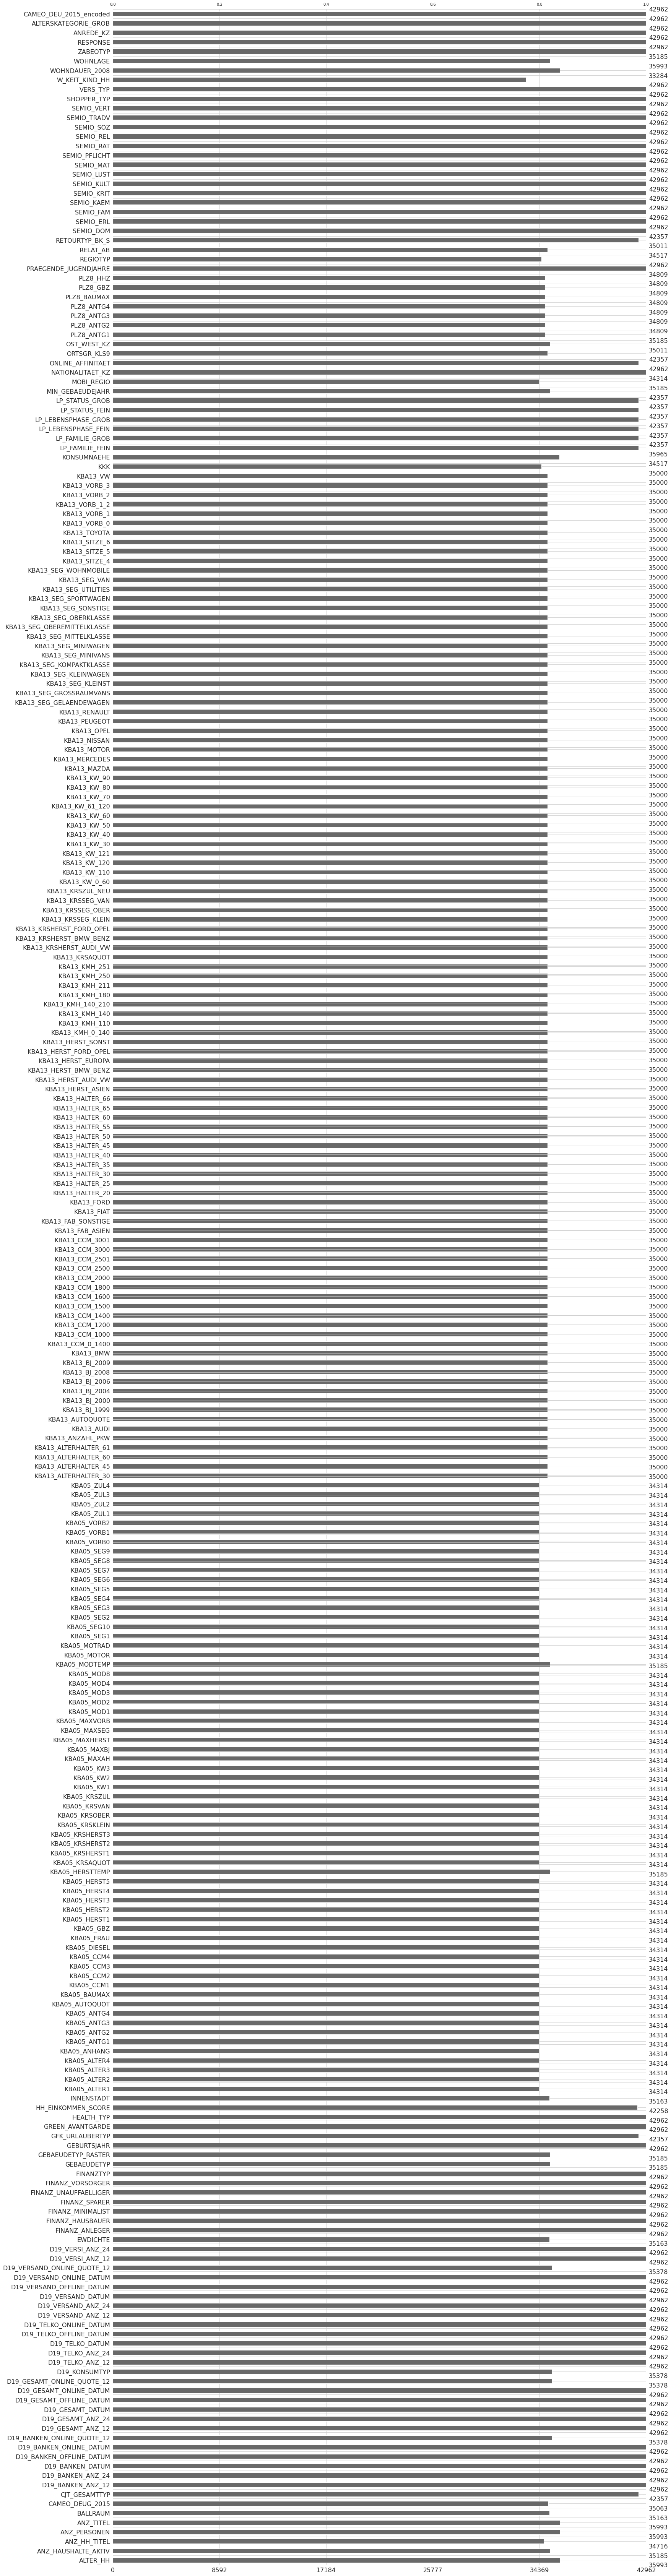

In [509]:
msno.bar(mailout_train)
plt.show()

In [510]:
mailout_train['OST_WEST_KZ'].replace('O', 0, inplace=True)
mailout_train['OST_WEST_KZ'].replace('W', 1, inplace=True)

In [511]:
RESPONSE = mailout_train['RESPONSE']
RESPONSE

0        0
1        0
2        0
3        0
4        0
        ..
42957    0
42958    0
42959    0
42960    0
42961    0
Name: RESPONSE, Length: 42962, dtype: int64

In [512]:
mailout_train.drop('RESPONSE', axis=1,inplace=True)

In [513]:
# impute missing data and standardize mailout_train excluding response variable
mailout_train = impute_missing_values(mailout_train)
#mailout_train = log_standardize(mailout_train)
mailout_train

ALTER_HH  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL  \
0           8.0                 15.0           0.0           1.0        0.0   
1          13.0                  1.0           0.0           2.0        0.0   
2           9.0                  0.0           0.0           0.0        0.0   
3           6.0                  4.0           0.0           2.0        0.0   
4           9.0                 53.0           0.0           1.0        0.0   
...         ...                  ...           ...           ...        ...   
42957       0.0                  1.0           0.0           2.0        0.0   
42958       0.0                  1.0           0.0           2.0        0.0   
42959      16.0                  2.0           0.0           3.0        0.0   
42960      18.0                  3.0           0.0           3.0        0.0   
42961      13.0                  3.0           0.0           1.0        0.0   

       BALLRAUM  CAMEO_DEUG_2015  CJT_GESAMTTYP  D19_BANKEN_ANZ_12  \
0           5.0              5.0            2.0                0.0   
1           5.0              5.0            2.0                1.0   
2           1.0              2.0            4.0                0.0   
3           2.0              2.0            2.0                0.0   
4           4.0              7.0            6.0                0.0   
...         ...              ...            ...                ...   
42957       2.0              3.0            3.0                0.0   
42958       6.0              6.0            3.0                0.0   
42959       6.0              4.0            5.0                0.0   
42960       6.0              8.0            5.0                2.0   
42961       6.0              4.0            2.0                0.0   

       D19_BANKEN_ANZ_24  ...  SEMIO_VERT  SHOPPER_TYP  VERS_TYP  \
0                    0.0  ...         3.0          3.0       2.0   
1                    1.0  ...         4.0          2.0       1.0   
2                    1.0  ...         7.0          3.0       1.0   
3                    0.0  ...         2.0          1.0       2.0   
4                    0.0  ...         7.0          1.0       1.0   
...                  ...  ...         ...          ...       ...   
42957                0.0  ...         7.0          3.0       1.0   
42958                0.0  ...         5.0          2.0       2.0   
42959                0.0  ...         7.0          3.0       1.0   
42960                3.0  ...         5.0          3.0       1.0   
42961                0.0  ...         4.0          3.0       1.0   

       W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  ZABEOTYP  ANREDE_KZ  \
0                 6.0             9.0       3.0       3.0        2.0   
1                 4.0             9.0       7.0       1.0        2.0   
2                 6.0             9.0       2.0       3.0        1.0   
3                 6.0             9.0       1.0       3.0        2.0   
4                 6.0             9.0       3.0       3.0        1.0   
...               ...             ...       ...       ...        ...   
42957             4.0             8.0       7.0       1.0        1.0   
42958             5.0             9.0       7.0       1.0        1.0   
42959             2.0             9.0       7.0       1.0        1.0   
42960             2.0             9.0       2.0       3.0        2.0   
42961             6.0             9.0       7.0       3.0        2.0   

       ALTERSKATEGORIE_GROB  CAMEO_DEU_2015_encoded  
0                       4.0                    21.0  
1                       3.0                    19.0  
2                       4.0                     8.0  
3                       4.0                     8.0  
4                       3.0                    31.0  
...                     ...                     ...  
42957                   4.0                    11.0  
42958                   3.0                    25.0  
42959                   4.0                    13

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


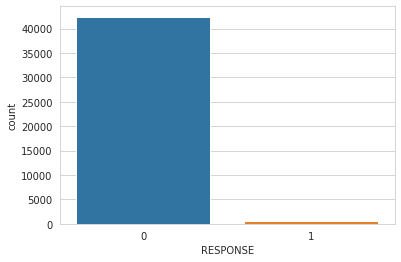

In [514]:
sns.countplot(RESPONSE)
plt.show();

##### Training, Testing and Evaluation

In [515]:
def train_test(X,y):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
  print(X_train.shape)
  print(X_val.shape)
  print(y_train.shape)
  print(y_val.shape)
  return X_train, X_val, y_train, y_val

In [516]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train, RESPONSE)

In [523]:

def fit_evaluate_model(model, X_train, X_val, y_train, y_val):
    """
    Fits a model to the training data, evaluates it on the validation data, and returns the evaluation results.
    
    Args:
    model: a supervised learning model that implements the 'fit' and 'predict_proba' methods
    X_train: a numpy array or pandas dataframe containing the training features
    X_val: a numpy array or pandas dataframe containing the validation features
    y_train: a numpy array or pandas series containing the training labels
    y_val: a numpy array or pandas series containing the validation labels
    
    Returns:
    A dictionary with the following keys:
    - 'train_auc': the area under the ROC curve for the training data
    - 'val_auc': the area under the ROC curve for the validation data
    """
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Compute the predicted probabilities for the training and validation data
    y_val_pred = model.predict(X_val)
    
    # Compute the AUC score for the training and validation data
    val_auc = roc_auc_score(y_val, y_val_pred)
    
    # Return the evaluation results
    return y_val_pred, val_auc

In [524]:
models = [('Logistic Regression', LogisticRegression(random_state=42, solver = 'lbfgs')),
          ('Gradient Boost', GradientBoostingClassifier(n_estimators=100, learning_rate = 0.1, random_state=42)),
          ('Naive Bayes', GaussianNB()),
          ("AdaBoostClassifier", AdaBoostClassifier(n_estimators=100,learning_rate = 0.1,random_state=42)),
          ('RandomForestClassifier', RandomForestClassifier(n_estimators=100, random_state=42)),
          ('XGBoost', xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3))
]
results={'MODEL':[],
         'AUCROC_SCORE':[],
         'y_pred':[], 
         }

In [525]:
for name, model in models:
  y_pred, score = fit_evaluate_model(model, X_train, X_val, y_train, y_val)
  results["MODEL"].append(name)
  results["AUCROC_SCORE"].append(score)
  results["y_pred"].append(y_pred)
  

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [526]:
results

{'MODEL': ['Logistic Regression',
  'Gradient Boost',
  'Naive Bayes',
  'AdaBoostClassifier',
  'RandomForestClassifier',
  'XGBoost'],
 'AUCROC_SCORE': [0.5, 0.5033356017626369, 0.5132891775708491, 0.5, 0.5, 0.5],
 'y_pred': [array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 1, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0])]}

##### Balance Dataset

In [527]:
from imblearn.over_sampling import SMOTE

def smote_oversample(X, y, random_state=42):
    """
    Perform SMOTE oversampling on the input data.
    """
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(X_resampled.shape, y_resampled.shape)
    return X_resampled, y_resampled

In [528]:
X_resampled, y_resampled = smote_oversample(mailout_train, RESPONSE)

(84860, 270) (84860,)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


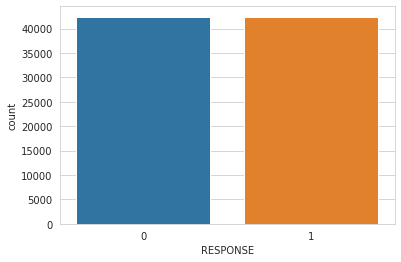

In [529]:
sns.countplot(y_resampled)
plt.show();

In [530]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled)

In [531]:
models = [('Logistic Regression', LogisticRegression(random_state=42, solver = 'lbfgs')),
          ('Gradient Boost', GradientBoostingClassifier(n_estimators=100, learning_rate = 0.1, random_state=42)),
          ('Naive Bayes', GaussianNB()),
          ("AdaBoostClassifier", AdaBoostClassifier(n_estimators=100,learning_rate = 0.1,random_state=42)),
          ('RandomForestClassifier', RandomForestClassifier(n_estimators=100, random_state=42)),
          ('XGBoost', xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3))
]
results={'MODEL':[],
         'AUCROC_SCORE':[],
         'y_pred':[], 
         }

In [532]:
for name, model in models:
  y_pred, score, time_spent = fit_evaluate_model(model, X_train, X_val, y_train, y_val)
  results["MODEL"].append(name)
  results["AUCROC_SCORE"].append(score)
  results["y_pred"].append(y_pred)
  

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [533]:
results

{'MODEL': ['Logistic Regression',
  'Gradient Boost',
  'Naive Bayes',
  'AdaBoostClassifier',
  'RandomForestClassifier',
  'XGBoost'],
 'AUCROC_SCORE': [0.6352494883054578,
  0.9400431751990566,
  0.7037230388301281,
  0.8932912690646766,
  0.941175835397442,
  0.9392397725525536],
 'y_pred': [array([1, 0, 0, ..., 0, 0, 1]),
  array([1, 0, 0, ..., 0, 0, 0]),
  array([1, 1, 1, ..., 0, 0, 1]),
  array([1, 0, 1, ..., 0, 0, 0]),
  array([1, 0, 0, ..., 0, 0, 0]),
  array([1, 0, 0, ..., 0, 0, 0])]}

In [534]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred):
    """
    Plot a confusion matrix using the predicted and actual labels.
    """
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

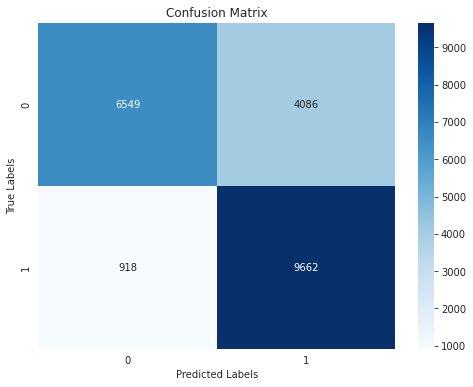

In [536]:
ada = AdaBoostClassifier(n_estimators=100,learning_rate = 0.01,random_state=42)
y_pred2, score,_ = fit_evaluate_model(ada, X_train, X_val, y_train, y_val)
from sklearn.metrics import classification_report
plot_confusion_matrix(y_val, y_pred2)

In [537]:
print(score)

0.7645147056078878


The model accuracy improve after balancing the dataset

#### Predict on mailout_test

In [538]:
mailout_test = pd.read_csv('', sep=';')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [539]:
mailout_test.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  1754         2         1.0       7.0          NaN          NaN   
1  1770        -1         1.0       0.0          NaN          NaN   
2  1465         2         9.0      16.0          NaN          NaN   
3  1470        -1         7.0       0.0          NaN          NaN   
4  1478         1         1.0      21.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                   6.0                  2.0  ...   
1          NaN          NaN                   0.0                 20.0  ...   
2          NaN          NaN                  11.0                  2.0  ...   
3          NaN          NaN                   0.0                  1.0  ...   
4          NaN          NaN                  13.0                  1.0  ...   

   VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0  4.0       5.0         6.0      3.0             6.0             9.0   
1  1.0       5.0         2.0      1.0             6.0             9.0   
2  3.0       9.0         6.0      3.0             2.0             9.0   
3  2.0       6.0         6.0      3.0             NaN             9.0   
4  1.0       2.0         4.0      3.0             3.0             9.0   

   WOHNLAGE ZABEOTYP ANREDE_KZ ALTERSKATEGORIE_GROB  
0       3.0        3         1                    4  
1       5.0        3         1                    4  
2       4.0        3         2                    4  
3       2.0        3         2                    4  
4       7.0        4         2                    4  

[5 rows x 366 columns]

In [540]:
mailout_test.shape

(42833, 366)

In [541]:
process_18_19(mailout_test)

In [542]:
LNR = mailout_test['LNR']

In [543]:
drop_columns(mailout_test, cols_to_drop)

Before : (42833, 366)
After : (42833, 270)


In [544]:
mailout_test, _ = nominal_encoding(mailout_test, 'CAMEO_DEU_2015')

In [545]:
mailout_test['OST_WEST_KZ'].replace('O', 0, inplace=True)
mailout_test['OST_WEST_KZ'].replace('W', 1, inplace=True)

In [546]:
mailout_test = impute_missing_values(mailout_test)

In [547]:
mailout_pred = ada.predict_proba(mailout_test)
prediction_df = pd.DataFrame(index = LNR, data = mailout_pred[:,1])
prediction_df.rename(columns={0:'RESPONSE'}, inplace=True)

In [548]:
prediction_df.head()

RESPONSE
LNR           
1754  0.519077
1770  0.463203
1465  0.299829
1470  0.256332
1478  0.461734

**Limitations**
1. If I had more computing memory, I would try using a GridSearchCV to find optimal parameters for my chosen model for optimality.
2. If there was more information on the features and their meanings, it would be helpful for feature engineering. Most of the columns are not included and described in the dictionary files given.